# Zadanie 2: optymalizacja z ograniczeniami

Termin realizacji: 31 marca 2025

Wybierz funkcję testową wykorzystaną w zadaniu 1.

Zadanie do oddania przez MS Teams. Do oddania: kod oraz krótkie sprawozdanie w PDF (można na przykład przy użyciu `quarto render notebook.ipynb --to pdf`).

## Na 3.0

Do realizacji:

1. Dodaj ograniczenie postaci $x_1^2 + x_2 + b = 0$ ze stałą $b$ dopasowaną w taki sposób, aby żadne minimum lokalne (przynajmniej w zakresie w którym losowany jest punkt początkowy) nie spełniają ograniczenia.
2. Zaimplementuj metodę funkcji kary do rozwiązania tego problemu.
3. Wylosuj 10 punktów z dziedziny przeszukiwania z tabelki. Dla każdego z nich przeprowadź 100 kroków optymalizacji metodą największego spadku ze stałym krokiem. Narysuj wykres zależności wartości funkcji optymalizowanej od kroku optymalizacji.
4. Przeprowadź procedurę dla kilku kroków. Spróbuj zilustrować brak zbieżności, szybką zbieżność i powolną zbieżność.

## Na 4.0

Do realizacji:

1. Punkty z zadania na 3.0.
2. Zamień metodę największego spadku na metodę gradientów sprzężonych.

## Na 5.0

Do realizacji:

1. Punkty z zadania na 4.0.
2. Wykonaj benchmarking metody z użyciem `BenchmarkTools.jl`. Zanotuj czasy działania wywołań optymalizacji oraz liczbę alokacji. Spróbuj zoptymalizować działanie funkcji korzystając wymienionych tu rad: [Julia performance tips](https://docs.julialang.org/en/v1/manual/performance-tips/). W sprawozdaniu napisz jakie zmiany wykonane i jak wpłynęły na czas działania programu.


In [1]:
using Random
using Plots
using Distributions

# Wybrana funckcja testowa

In [2]:
function himmelblau(x, y)
   return (x^2 + y - 11)^2 + (x + y^2 - 7)^2
end

himmelblau (generic function with 1 method)

In [3]:
function himmelblau_gradient(x, y)
   df_dx = 4 * x * (x^2 + y - 11) + 2 * (x + y^2 - 7)
   df_dy = 2 * (x^2 + y - 11) + 4 * y * (x + y^2 - 7)
   return df_dx, df_dy
end

himmelblau_gradient (generic function with 1 method)

# Ograniczenie: x^2 + y + b = 0

In [4]:
function constraint(x, y, b)
   return x^2 + y + b
end

constraint (generic function with 1 method)

In [5]:
function constraint_grad(x, y, b)
   return (2*x, 1) 
end

constraint_grad (generic function with 1 method)

# Kara

## Funkcja kary

In [6]:
function penalty_function(fun1, constr_fun, x, y, b, μ)
   return fun1(x, y) + μ * constr_fun(x, y, b)^2
end

penalty_function (generic function with 1 method)

## Gradient kary

In [7]:
function penalty_gradient(fun_grad, constr, constr_grad, x, y, b, μ)
   df_dx, df_dy = fun_grad(x, y)
   constraint_value = constr(x, y, b)
   constr_grad__value_vect = constr_grad(x, y, b)
   df_dx += 2 * μ * constraint_value .* constr_grad__value_vect[1]
   df_dy += 2 * μ * constraint_value .* constr_grad__value_vect[2]
   return df_dx, df_dy
end

penalty_gradient (generic function with 1 method)

# Metoda największego spadku ze stałym krokiem

In [8]:
function gradient_descent_fixed_step(fun, fun_grad, constr, constr_grad, x, y, α, iterations, b, μ)
   cost_history = []
   
   for i in 1:iterations
       grad_x, grad_y = penalty_gradient(fun_grad, constr, constr_grad, x, y, b, μ)
       x -= α * grad_x
       y -= α * grad_y
       push!(cost_history, penalty_function(fun, constr, x, y, b, μ))
   end
   
   return x, y, cost_history
end

gradient_descent_fixed_step (generic function with 1 method)

# Wywołanie

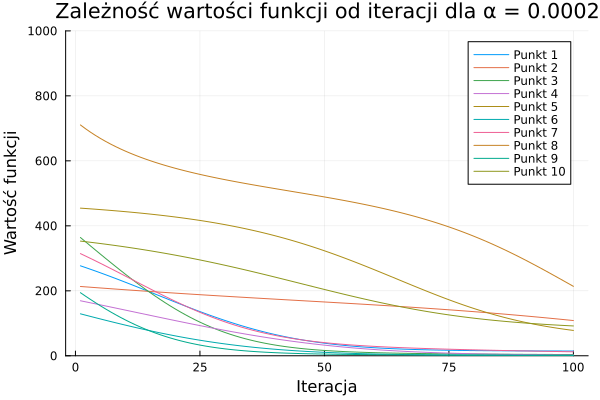

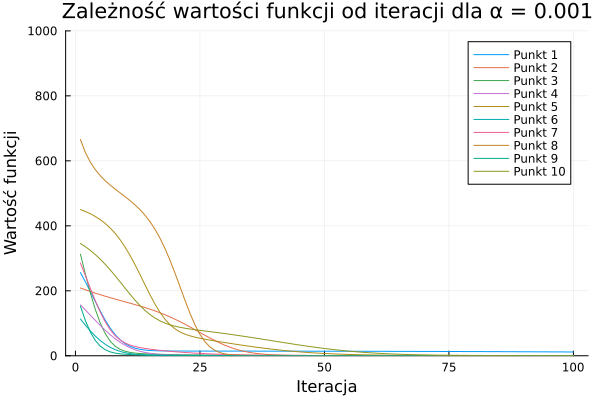

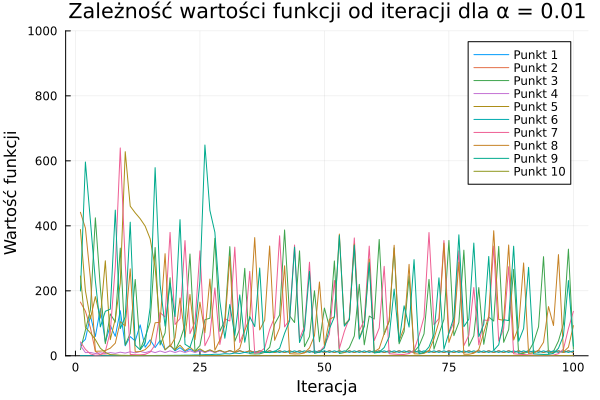

In [9]:
# Parametry
Random.seed!(42)
num_points = 10
start_points = [(rand(Uniform(-5, 5)), rand(Uniform(-5, 5))) for _ in 1:num_points]
α_values = [0.0002, 0.001, 0.01]  # Różne wartości kroku
iterations = 100
b = -10  # Stała b dobrana tak, aby minima lokalne nie spełniały ograniczenia
μ = 2  # Parametr kary

# Optymalizacja i rysowanie wykresów
for α in α_values
    all_cost_histories = []
    
    for (x0, y0) in start_points
        x_opt, y_opt, cost_history = gradient_descent_fixed_step(himmelblau, himmelblau_gradient, constraint, constraint_grad, x0, y0, α, iterations, b, μ)
        push!(all_cost_histories, cost_history)
    end
    
    plt = plot(1:iterations, all_cost_histories[1], label="Punkt 1", xlabel="Iteracja", ylabel="Wartość funkcji", title="Zależność wartości funkcji od iteracji dla α = $α", ylim=(0, 1000))
    for i in 2:num_points
        plot!(plt, 1:iterations, all_cost_histories[i], label="Punkt $i")
    end
    
    display(plt)
end

# Metoda gradientów sprzężonych

In [10]:
function conjugate_gradient(fun, fun_grad, constr, constr_grad, x, y, α, iterations, b, μ)
    cost_history = []
    grad_x, grad_y = penalty_gradient(fun_grad, constr, constr_grad, x, y, b, μ)
    d_x, d_y = -grad_x, -grad_y
    # push!(cost_history, penalty_function(fun, constr, x, y, b, μ))
    
    for k in 1:iterations
        old_grad_x, old_grad_y = grad_x, grad_y
        old_d_x, old_d_y = d_x, d_y
        
        x += α * d_x
        y += α * d_y
        
        grad_x, grad_y = penalty_gradient(fun_grad, constr, constr_grad, x, y, b, μ)
        
        beta = (grad_x*(grad_x - old_grad_x) + grad_y*(grad_y - old_grad_y)) / (old_grad_x^2 + old_grad_y^2)
        
        d_x = -grad_x + beta * old_d_x
        d_y = -grad_y + beta * old_d_y
        
        push!(cost_history, penalty_function(fun, constr, x, y, b, μ))
    end
    
    return x, y, cost_history
end



conjugate_gradient (generic function with 1 method)

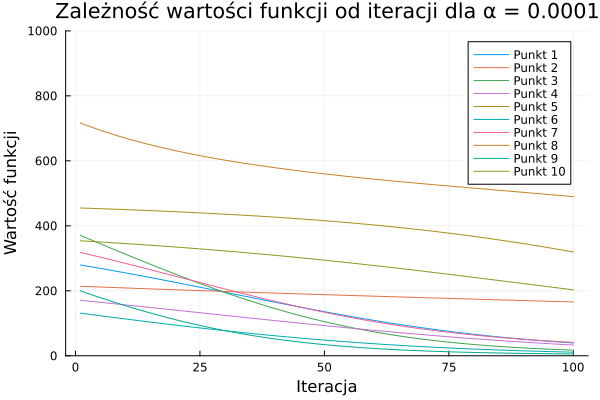

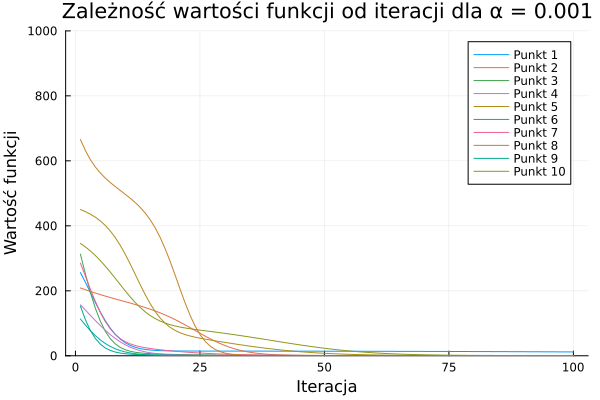

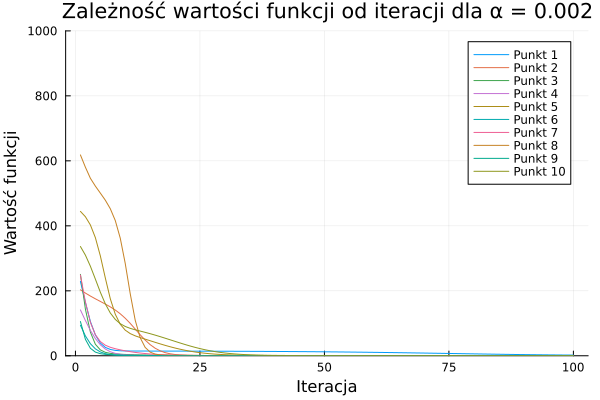

In [11]:
# Parametry
Random.seed!(42)
num_points = 10
start_points = [(rand(Uniform(-5, 5)), rand(Uniform(-5, 5))) for _ in 1:num_points]
α_values = [0.0001, 0.001, 0.002]  # Różne wartości kroku
iterations = 100
b = -10  # Stała b dobrana tak, aby minima lokalne nie spełniały ograniczenia
μ = 2  # Parametr kary

# Optymalizacja i rysowanie wykresów
for α in α_values
    all_cost_histories = []
    
    for (x0, y0) in start_points
        x_opt, y_opt, cost_history = conjugate_gradient(himmelblau, himmelblau_gradient, constraint, constraint_grad, x0, y0, α, iterations, b, μ)
        push!(all_cost_histories, cost_history)
    end
    
    plt = plot(1:iterations, all_cost_histories[1], label="Punkt 1", xlabel="Iteracja", ylabel="Wartość funkcji", title="Zależność wartości funkcji od iteracji dla α = $α", ylim=(0, 1000))
    for i in 2:num_points
        plot!(plt, 1:iterations, all_cost_histories[i], label="Punkt $i")
    end
    
    display(plt)
end